In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import numpy as np
import matplotlib.pyplot as plt
import cv2

import sys
sys.path.append('/mnt/disk1/project/SMhospital/capsule/ce_packages')

from ce_utils import load_data, one_hot, test_batch_idxs, batch_flatten
from ce_utils import model_prob
from ce_utils import classification_metric
from ce_model import binary_model, ensemble_model

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Load Data

In [2]:
neg_nh_img, neg_nh_name = load_data('total', 'n', 'neg', data = 'sm_core/nh', extract_name = True)
neg_nd_img, neg_nd_name = load_data('total', 'n', 'neg', data = 'sm_core/nd', extract_name = True)
neg_img, neg_name = np.vstack([neg_nh_img, neg_nd_img]), np.hstack([neg_nh_name, neg_nd_name])
redspot_img, redspot_name = load_data('total', 'h', 'redspot', data = 'sm_core/nh', extract_name = True)
angio_img, angio_name = load_data('total', 'h', 'angio', data = 'sm_core/nh', extract_name = True)
active_img, active_name = load_data('total', 'h', 'active', data = 'sm_core/nh', extract_name = True)
ero_img, ero_name = load_data('total', 'd', 'ero', data = 'sm_core/nd', extract_name = True)
ulcer_img, ulcer_name = load_data('total', 'd', 'ulcer', data = 'sm_core/nd', extract_name = True)
str_img, str_name = load_data('total', 'd', 'str', data = 'sm_core/nd', extract_name = True)

In [3]:
neg_nh_label = one_hot(neg_nh_img, 0)
neg_nd_label = one_hot(neg_nd_img, 0)
neg_label = one_hot(neg_img, 0)
redspot_label = one_hot(redspot_img, 1)
angio_label = one_hot(angio_img, 1)
active_label = one_hot(active_img, 1)
ero_label = one_hot(ero_img, 1)
ulcer_label = one_hot(ulcer_img, 1)
str_label = one_hot(str_img, 1)

print("total negative:",neg_img.shape, neg_label.shape)
print("negative for nh:",neg_nh_img.shape, neg_nh_label.shape)
print("negative for nd:",neg_nd_img.shape, neg_nd_label.shape)
print('')
print("red spot:",redspot_img.shape, redspot_label.shape)
print("angioectasia:",angio_img.shape, angio_label.shape)
print("active_bleeding:",active_img.shape, active_label.shape)
print("erosion:",ero_img.shape, ero_label.shape)
print("ulcer:",ulcer_img.shape, ulcer_label.shape)
print("stricture:",str_img.shape, str_label.shape)

total negative: (1492, 512, 512, 3) (1492, 2)
negative for nh: (490, 512, 512, 3) (490, 2)
negative for nd: (1002, 512, 512, 3) (1002, 2)

red spot: (227, 512, 512, 3) (227, 2)
angioectasia: (14, 512, 512, 3) (14, 2)
active_bleeding: (249, 512, 512, 3) (249, 2)
erosion: (485, 512, 512, 3) (485, 2)
ulcer: (471, 512, 512, 3) (471, 2)
stricture: (46, 512, 512, 3) (46, 2)


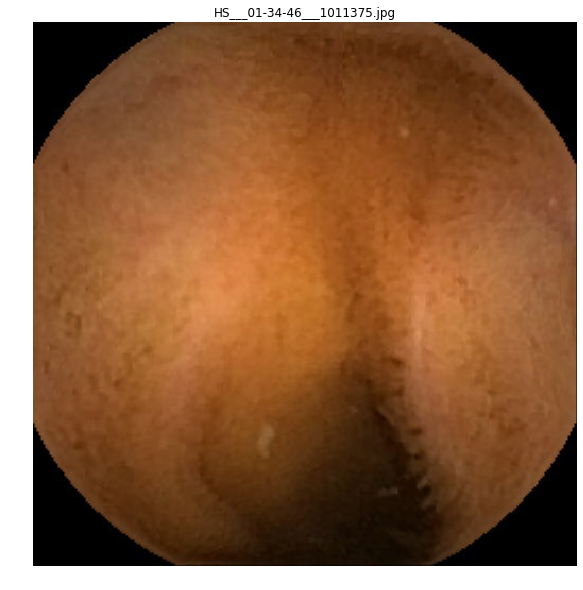

In [4]:
fig = plt.figure(figsize = (10, 10))
plt.title(neg_nh_name[0])
plt.imshow(cv2.cvtColor(neg_nh_img[0], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Model Inference

In [5]:
nh_list = sorted([i[:-5] for i in os.listdir('./model') if 'meta' in i and 'NH_sm_diff' in i])
nd_list = sorted([i[:-5] for i in os.listdir('./model') if 'meta' in i and 'ND_sm_diff' in i])
b_list = sorted([i[:-5] for i in os.listdir('./model') if 'meta' in i and 'B_sm_diff' in i])

In [6]:
nh_list

['NH_sm_diff_2001140224_2200_val_mean_loss_0.373969',
 'NH_sm_diff_2001140249_3560_val_mean_loss_0.367667',
 'NH_sm_diff_2001140249_3570_val_mean_loss_0.361913',
 'NH_sm_diff_2001140306_4520_val_mean_loss_0.361825',
 'NH_sm_diff_2001140311_4770_val_mean_loss_0.359619']

In [7]:
nd_list

['ND_sm_diff_2001140248_3410_val_mean_loss_0.191786',
 'ND_sm_diff_2001140248_3420_val_mean_loss_0.184474',
 'ND_sm_diff_2001140248_3430_val_mean_loss_0.170071',
 'ND_sm_diff_2001140249_3490_val_mean_loss_0.169697',
 'ND_sm_diff_2001140306_4390_val_mean_loss_0.168157']

In [8]:
b_list

['B_sm_diff_2001140227_2430_val_mean_loss_0.344034',
 'B_sm_diff_2001140228_2460_val_mean_loss_0.339793',
 'B_sm_diff_2001140244_3330_val_mean_loss_0.339760',
 'B_sm_diff_2001140244_3340_val_mean_loss_0.321615',
 'B_sm_diff_2001140245_3360_val_mean_loss_0.320436']

In [9]:
nh_path = './model/' + nh_list[-1]
nd_path = './model/' + nd_list[-1]
b_path = './model/' + b_list[-1]

NH_model = binary_model(nh_path)
ND_model = binary_model(nd_path)
E_model = ensemble_model(nh_path, nd_path)
B_model = binary_model(b_path)

W0114 14:17:38.937247 140116578305792 deprecation_wrapper.py:119] From /mnt/disk1/project/SMhospital/capsule/ce_packages/ce_model.py:107: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0114 14:17:45.153661 140116578305792 deprecation_wrapper.py:119] From /mnt/disk1/project/SMhospital/capsule/ce_packages/ce_model.py:108: The name tf.train.import_meta_graph is deprecated. Please use tf.compat.v1.train.import_meta_graph instead.

W0114 14:17:45.477202 140116578305792 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [10]:
neg_nh_output = model_prob(NH_model, neg_nh_img)
neg_nd_output = model_prob(ND_model, neg_nd_img)

#: 490 / Inference Time: 00:00:06
#: 1002 / Inference Time: 00:00:05


In [11]:
neg_e_output, _, _ = model_prob(E_model, neg_img, model_type = 'ensemble')
redspot_e_output, redspot_nh_output, redspot_nd_output = model_prob(E_model, redspot_img, model_type = 'ensemble')
angio_e_output, angio_nh_output, angio_nd_output = model_prob(E_model, angio_img, model_type = 'ensemble')
active_e_output, active_nh_output, active_nd_output = model_prob(E_model, active_img, model_type = 'ensemble')
ero_e_output, ero_nh_output, ero_nd_output = model_prob(E_model, ero_img, model_type = 'ensemble')
ulcer_e_output, ulcer_nh_output, ulcer_nd_output = model_prob(E_model, ulcer_img, model_type = 'ensemble')
str_e_output, str_nh_output, str_nd_output  = model_prob(E_model, str_img, model_type = 'ensemble')

#: 1492 / Inference Time: 00:00:16
#: 227 / Inference Time: 00:00:03
#: 14 / Inference Time: 00:00:00
#: 249 / Inference Time: 00:00:03
#: 485 / Inference Time: 00:00:06
#: 471 / Inference Time: 00:00:06
#: 46 / Inference Time: 00:00:01


In [12]:
neg_b_output = model_prob(B_model, neg_img)
redspot_b_output = model_prob(B_model, redspot_img)
angio_b_output = model_prob(B_model, angio_img)
active_b_output = model_prob(B_model, active_img)
ero_b_output = model_prob(B_model, ero_img)
ulcer_b_output = model_prob(B_model, ulcer_img)
str_b_output  = model_prob(B_model, str_img)

#: 1492 / Inference Time: 00:00:07
#: 227 / Inference Time: 00:00:01
#: 14 / Inference Time: 00:00:00
#: 249 / Inference Time: 00:00:01
#: 485 / Inference Time: 00:00:02
#: 471 / Inference Time: 00:00:02
#: 46 / Inference Time: 00:00:00


# Evaluation

In [13]:
cls = classification_metric()

## Accuracy per lesion

In [14]:
neg_nh_acc = cls.accuracy(neg_nh_label, neg_nh_output)
redspot_nh_acc = cls.accuracy(redspot_label, redspot_nh_output)
angio_nh_acc = cls.accuracy(angio_label, angio_nh_output)
active_nh_acc = cls.accuracy(active_label, active_nh_output)

Accuracy: 84.29 %
Accuracy: 81.94 %
Accuracy: 85.71 %
Accuracy: 98.39 %


In [15]:
neg_nd_acc = cls.accuracy(neg_nd_label, neg_nd_output)
ero_nd_acc = cls.accuracy(ero_label, ero_nd_output)
ulcer_nd_acc = cls.accuracy(ulcer_label, ulcer_nd_output)
str_nd_acc = cls.accuracy(str_label, str_nd_output)

Accuracy: 89.02 %
Accuracy: 96.08 %
Accuracy: 95.54 %
Accuracy: 97.83 %


In [16]:
neg_b_acc = cls.accuracy(neg_label, neg_b_output)
redspot_b_acc = cls.accuracy(redspot_label, redspot_b_output)
angio_b_acc = cls.accuracy(angio_label, angio_b_output)
active_b_acc = cls.accuracy(active_label, active_b_output)
ero_b_acc = cls.accuracy(ero_label, ero_b_output)
ulcer_b_acc = cls.accuracy(ulcer_label, ulcer_b_output)
str_b_acc = cls.accuracy(str_label, str_b_output)

Accuracy: 89.88 %
Accuracy: 61.23 %
Accuracy: 42.86 %
Accuracy: 89.56 %
Accuracy: 70.93 %
Accuracy: 83.65 %
Accuracy: 95.65 %


In [17]:
neg_e_acc = cls.accuracy(neg_label, neg_e_output)
redspot_e_acc = cls.accuracy(redspot_label, redspot_e_output)
angio_e_acc = cls.accuracy(angio_label, angio_e_output)
active_e_acc = cls.accuracy(active_label, active_e_output)
ero_e_acc = cls.accuracy(ero_label, ero_e_output)
ulcer_e_acc = cls.accuracy(ulcer_label, ulcer_e_output)
str_e_acc = cls.accuracy(str_label, str_e_output)

Accuracy: 78.89 %
Accuracy: 97.80 %
Accuracy: 100.00 %
Accuracy: 99.20 %
Accuracy: 98.14 %
Accuracy: 97.45 %
Accuracy: 97.83 %


## Confusion Matrix

In [18]:
nh_outputs = np.vstack([neg_nh_output, redspot_nh_output, angio_nh_output, active_nh_output])
labels = np.vstack([neg_nh_label, redspot_label, angio_label, active_label])

nh_CM = cls.con_mat(labels, nh_outputs)

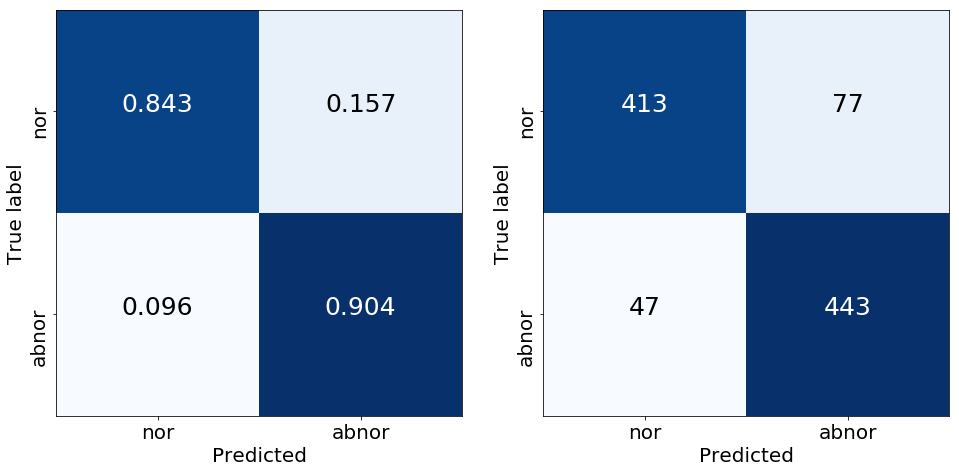

In [19]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(nh_CM, value_size = 25, label_size = 20)
plt.subplot(122)
cls.plot_cm(nh_CM, value_size = 25, label_size = 20, mode = 'num')
plt.show()

In [20]:
nd_outputs = np.vstack([neg_nd_output, ero_nd_output, ulcer_nd_output, str_nd_output])
labels = np.vstack([neg_nd_label, ero_label, ulcer_label, str_label])

nd_CM = cls.con_mat(labels, nd_outputs)

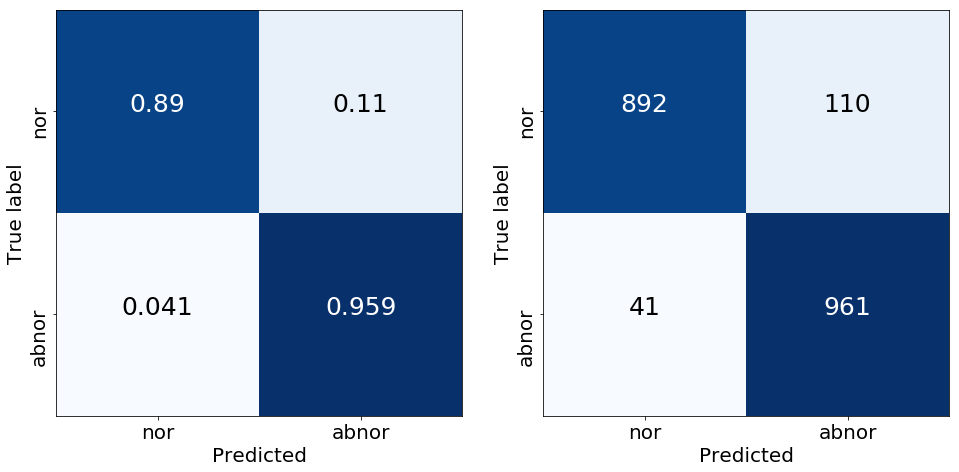

In [21]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(nd_CM, value_size = 25, label_size = 20)
plt.subplot(122)
cls.plot_cm(nd_CM, value_size = 25, label_size = 20, mode = 'num')
plt.show()

In [22]:
e_outputs = np.vstack([neg_e_output, redspot_e_output, angio_e_output, active_e_output, ero_e_output, ulcer_e_output, str_e_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

e_CM = cls.con_mat(labels, e_outputs)

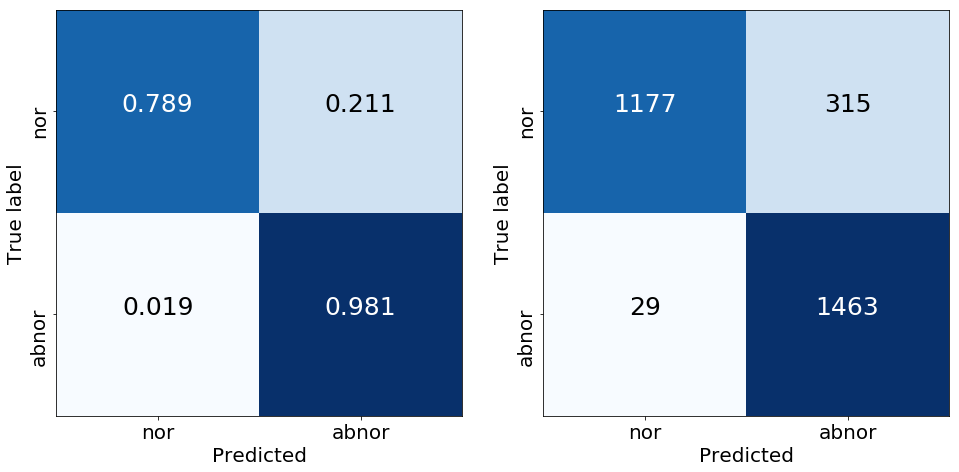

In [23]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(e_CM, value_size = 25, label_size = 20)
plt.subplot(122)
cls.plot_cm(e_CM, value_size = 25, label_size = 20, mode = 'num')
plt.show()

In [24]:
b_outputs = np.vstack([neg_b_output, redspot_b_output, angio_b_output, active_b_output, ero_b_output, ulcer_b_output, str_b_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

b_CM = cls.con_mat(labels, b_outputs)

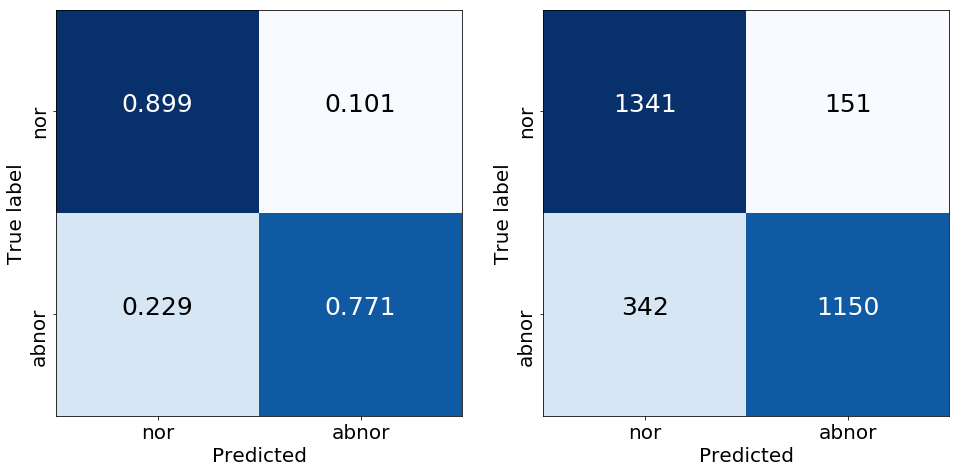

In [25]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(b_CM, value_size = 25, label_size = 20)
plt.grid(False)
plt.subplot(122)
cls.plot_cm(b_CM, value_size = 25, label_size = 20, mode = 'num')
plt.grid(False)
plt.show()

## ROC curve

In [26]:
from scipy.stats import sem, t
from scipy import mean

def conf_interval(data, conf_level = 0.95, mode = 'value', metric = 'Accr'):
    n = len(data)
    m = mean(data)
    std_err = sem(data)
    h = std_err * t.ppf((1 + conf_level) / 2, n - 1)

    start = m - h
    end = m + h
    
    if mode == 'value':
        return m, start, end
    elif mode == 'print':
        return print("{} --- {:.2f} ({:.2f} ~ {:.2f})".format(metric, m, start, end))

In [27]:
from sklearn.model_selection import KFold

In [28]:
def k_fold_idx(n_fold, dataset):
    kf = KFold(n_splits = n_fold, shuffle = True)
    train_idxs = []
    test_idxs = []
    for train_idx, test_idx in kf.split(dataset):
        train_idxs.append(train_idx)
        test_idxs.append(test_idx)
    return train_idxs, test_idxs

In [29]:
n_g = 10

_, neg_nh_idxs = k_fold_idx(n_fold = n_g, dataset = neg_nh_label)
_, neg_nd_idxs = k_fold_idx(n_fold = n_g, dataset = neg_nd_label)
_, neg_idxs = k_fold_idx(n_fold = n_g, dataset = neg_label)
_, redspot_idxs = k_fold_idx(n_fold = n_g, dataset = redspot_label)
_, angio_idxs = k_fold_idx(n_fold = n_g, dataset = angio_label)
_, active_idxs = k_fold_idx(n_fold = n_g, dataset = active_label)
_, ero_idxs = k_fold_idx(n_fold = n_g, dataset = ero_label)
_, ulcer_idxs = k_fold_idx(n_fold = n_g, dataset = ulcer_label)
_, str_idxs = k_fold_idx(n_fold = n_g, dataset = str_label)

In [30]:
from sklearn.metrics import roc_curve, auc

e_aucs, b_aucs = [], []

for n_idx, r_idx, an_idx, ac_idx, e_idx, u_idx, s_idx in zip(neg_idxs, redspot_idxs, angio_idxs, active_idxs,
                                                               ero_idxs, ulcer_idxs, str_idxs):
    
    b_outputs = np.vstack([neg_b_output[n_idx], redspot_b_output[r_idx], angio_b_output[an_idx], active_b_output[ac_idx], 
                           ero_b_output[e_idx], ulcer_b_output[u_idx], str_b_output[s_idx]])
    e_outputs = np.vstack([neg_e_output[n_idx], redspot_e_output[r_idx], angio_e_output[an_idx], active_e_output[ac_idx], 
                           ero_e_output[e_idx], ulcer_e_output[u_idx], str_e_output[s_idx]])
    labels = np.vstack([neg_label[n_idx], redspot_label[r_idx], angio_label[an_idx], active_label[ac_idx], 
                        ero_label[e_idx], ulcer_label[u_idx], str_label[s_idx]])
    e_fpr, e_tpr, thresholds = roc_curve(labels[:, 1], e_outputs[:,1])
    b_fpr, b_tpr, thresholds = roc_curve(labels[:, 1], b_outputs[:,1])
    e_aucs.append(auc(e_fpr, e_tpr))
    b_aucs.append(auc(b_fpr, b_tpr))

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


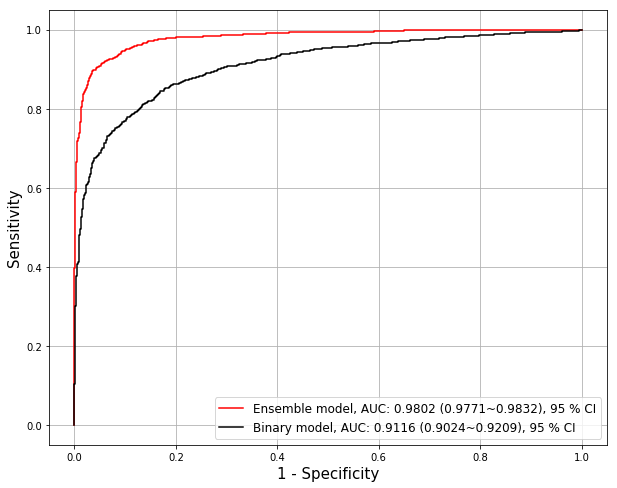

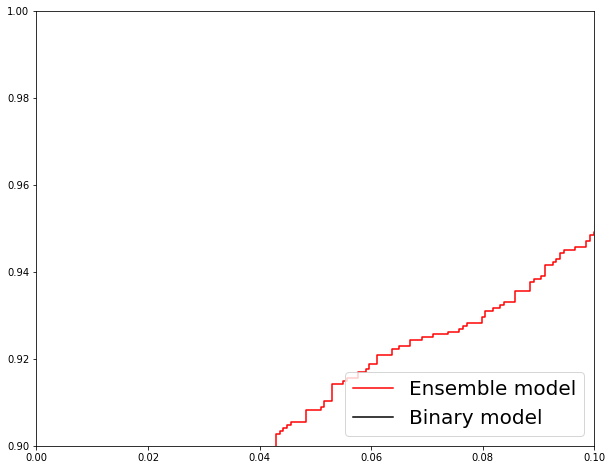

In [31]:
e_auc_m, e_auc_l, e_auc_u = conf_interval(e_aucs, mode = 'value')
b_auc_m, b_auc_l, b_auc_u = conf_interval(b_aucs, mode = 'value')

b_outputs = np.vstack([neg_b_output, redspot_b_output, angio_b_output, active_b_output, ero_b_output, ulcer_b_output, str_b_output])
e_outputs = np.vstack([neg_e_output, redspot_e_output, angio_e_output, active_e_output, ero_e_output, ulcer_e_output, str_e_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

e_fpr, e_tpr, thresholds = roc_curve(labels[:, 1], e_outputs[:,1])
b_fpr, b_tpr, thresholds = roc_curve(labels[:, 1], b_outputs[:,1])

fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-', label="Ensemble model, AUC: {:.4f} ({:.4f}~{:.4f}), 95 % CI".format(e_auc_m, e_auc_l, e_auc_u))
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model, AUC: {:.4f} ({:.4f}~{:.4f}), 95 % CI".format(b_auc_m, b_auc_l, b_auc_u))
plt.xlabel('1 - Specificity', fontsize = 15)
plt.ylabel('Sensitivity', fontsize = 15)
plt.legend(fontsize = 12)
plt.grid('on')
fig.show()

fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-', label="Ensemble model")
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model")
plt.xlim([0.0, 0.1])
plt.ylim([0.9, 1.0])
plt.legend(fontsize = 20, loc = 4)
fig.show()

## Statistics

![image](http://mblogthumb3.phinf.naver.net/20121114_106/istech7_1352875002440GYyqh_PNG/%B5%CE%C1%FD%B4%DC%C2%F7%C0%CC_%B0%CB%C1%A4%B9%E6%B9%FD%C8%E5%B8%A7%B5%B5.png?type=w2)

![image](https://t1.daumcdn.net/cfile/tistory/2743524658F2520C2A)

https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F1378B94E4F9C187F23

In [32]:
e_CM, b_CM = [], []

for n_idx, r_idx, an_idx, ac_idx, e_idx, u_idx, s_idx in zip(neg_idxs, redspot_idxs, angio_idxs, active_idxs,
                                                               ero_idxs, ulcer_idxs, str_idxs):
    
    b_outputs = np.vstack([neg_b_output[n_idx], redspot_b_output[r_idx], angio_b_output[an_idx], active_b_output[ac_idx], 
                           ero_b_output[e_idx], ulcer_b_output[u_idx], str_b_output[s_idx]])
    e_outputs = np.vstack([neg_e_output[n_idx], redspot_e_output[r_idx], angio_e_output[an_idx], active_e_output[ac_idx], 
                           ero_e_output[e_idx], ulcer_e_output[u_idx], str_e_output[s_idx]])
    labels = np.vstack([neg_label[n_idx], redspot_label[r_idx], angio_label[an_idx], active_label[ac_idx], 
                        ero_label[e_idx], ulcer_label[u_idx], str_label[s_idx]])
    print(labels.shape)
    e_CM.append(cls.con_mat(labels, e_outputs)), b_CM.append(cls.con_mat(labels, b_outputs))

(302, 2)
(301, 2)
(300, 2)
(300, 2)
(299, 2)
(298, 2)
(297, 2)
(296, 2)
(296, 2)
(295, 2)


In [33]:
b_metrices = []
e_metrices = []

for e_cm, b_cm in zip(e_CM, b_CM):
    b_metrices.append(cls.cm2metric(b_cm))
    e_metrices.append(cls.cm2metric(e_cm))
    
b_metrices = np.asarray(b_metrices)
e_metrices = np.asarray(e_metrices)

In [34]:
b_metrices

array([[0.82781457, 0.75      , 0.90666667, 0.7816092 , 0.890625  ],
       [0.8538206 , 0.78145695, 0.92666667, 0.80813953, 0.91472868],
       [0.81333333, 0.75496689, 0.87248322, 0.77844311, 0.85714286],
       [0.86333333, 0.8013245 , 0.9261745 , 0.82142857, 0.91666667],
       [0.82943144, 0.74      , 0.91946309, 0.77840909, 0.90243902],
       [0.81208054, 0.77181208, 0.85234899, 0.78881988, 0.83941606],
       [0.8047138 , 0.72972973, 0.87919463, 0.76608187, 0.85714286],
       [0.85472973, 0.78231293, 0.9261745 , 0.81176471, 0.91269841],
       [0.83783784, 0.79591837, 0.87919463, 0.8136646 , 0.86666667],
       [0.85084746, 0.80136986, 0.89932886, 0.82208589, 0.88636364]])

In [35]:
e_metrices

array([[0.90397351, 0.99342105, 0.81333333, 0.99186992, 0.84357542],
       [0.87707641, 0.98013245, 0.77333333, 0.97478992, 0.81318681],
       [0.85      , 0.98013245, 0.71812081, 0.97272727, 0.77894737],
       [0.89      , 0.96688742, 0.81208054, 0.96031746, 0.83908046],
       [0.88963211, 0.98      , 0.79865772, 0.97540984, 0.83050847],
       [0.8557047 , 0.95973154, 0.75167785, 0.94915254, 0.79444444],
       [0.8989899 , 0.99324324, 0.80536913, 0.99173554, 0.83522727],
       [0.88851351, 0.97278912, 0.80536913, 0.96774194, 0.83139535],
       [0.91216216, 0.99319728, 0.83221477, 0.992     , 0.85380117],
       [0.88135593, 0.98630137, 0.77852349, 0.98305085, 0.81355932]])

In [36]:
print("95 % CI\n")

print('Binary model')
conf_interval(100*b_metrices[:, 0], mode = 'print', metric = 'Accr')
conf_interval(100*b_metrices[:, 1], mode = 'print', metric = 'Sen')
conf_interval(100*b_metrices[:, 2], mode = 'print', metric = 'Spec')
conf_interval(100*b_metrices[:, 3], mode = 'print', metric = 'NPV')
conf_interval(100*b_metrices[:, 4], mode = 'print', metric = 'PPV')
print('')
print('Ensemble model')
conf_interval(100*e_metrices[:, 0], mode = 'print', metric = 'Accr')
conf_interval(100*e_metrices[:, 1], mode = 'print', metric = 'Sen')
conf_interval(100*e_metrices[:, 2], mode = 'print', metric = 'Spec')
conf_interval(100*e_metrices[:, 3], mode = 'print', metric = 'NPV')
conf_interval(100*e_metrices[:, 4], mode = 'print', metric = 'PPV')

95 % CI

Binary model
Accr --- 83.48 (82.01 ~ 84.95)
Sen --- 77.09 (75.23 ~ 78.95)
Spec --- 89.88 (87.97 ~ 91.78)
NPV --- 79.70 (78.24 ~ 81.17)
PPV --- 88.44 (86.45 ~ 90.43)

Ensemble model
Accr --- 88.47 (87.06 ~ 89.89)
Sen --- 98.06 (97.23 ~ 98.88)
Spec --- 78.89 (76.46 ~ 81.32)
NPV --- 97.59 (96.56 ~ 98.61)
PPV --- 82.34 (80.68 ~ 84.00)


### Equal-Variance Test

In [37]:
from scipy.stats import bartlett

accr_stats = bartlett(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = bartlett(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = bartlett(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = bartlett(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = bartlett(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("bartlett test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("bartlett test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("bartlett test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("bartlett test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("bartlett test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

bartlett test for accuracy: 0.013, pvalue=0.908141169561
bartlett test for sensitivity: 5.068, pvalue=0.024378018906
bartlett test for specificity: 0.502, pvalue=0.478811158207
bartlett test for negative predictive values: 1.074, pvalue=0.300042519975
bartlett test for positive predictive values: 0.276, pvalue=0.599246148355


In [38]:
from scipy.stats import levene

accr_stats = levene(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = levene(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = levene(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = levene(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = levene(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("levene test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("levene test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("levene test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("levene test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("levene test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

levene test for accuracy: 0.349, pvalue=0.562043087624
levene test for sensitivity: 6.873, pvalue=0.017292809590
levene test for specificity: 0.077, pvalue=0.784565935137
levene test for negative predictive values: 4.511, pvalue=0.047797330482
levene test for positive predictive values: 0.710, pvalue=0.410380202887


### Normality Test

In [39]:
from scipy.stats import ks_2samp

accr_stats = ks_2samp(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = ks_2samp(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = ks_2samp(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = ks_2samp(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = ks_2samp(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("Kolmogorov-Smirnov test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("Kolmogorov-Smirnov test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("Kolmogorov-Smirnov test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("Kolmogorov-Smirnov test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("Kolmogorov-Smirnov test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

Kolmogorov-Smirnov test for accuracy: 0.800, pvalue=0.002056766763
Kolmogorov-Smirnov test for sensitivity: 1.000, pvalue=0.000010825088
Kolmogorov-Smirnov test for specificity: 1.000, pvalue=0.000010825088
Kolmogorov-Smirnov test for negative predictive values: 1.000, pvalue=0.000010825088
Kolmogorov-Smirnov test for positive predictive values: 0.900, pvalue=0.000216501764


### Wilcoxon signed-ranks test (not normal and paired group)

In [40]:
from scipy.stats import wilcoxon

accr_stats = wilcoxon(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = wilcoxon(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = wilcoxon(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = wilcoxon(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = wilcoxon(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("wilcoxon signed-ranks test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("wilcoxon signed-ranks test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("wilcoxon signed-ranks test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("wilcoxon signed-ranks test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("wilcoxon signed-ranks test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

wilcoxon signed-ranks test for accuracy: 0.000, pvalue=0.005062032126
wilcoxon signed-ranks test for sensitivity: 0.000, pvalue=0.005062032126
wilcoxon signed-ranks test for specificity: 0.000, pvalue=0.004948477275
wilcoxon signed-ranks test for negative predictive values: 0.000, pvalue=0.005062032126
wilcoxon signed-ranks test for positive predictive values: 0.000, pvalue=0.005062032126


### Paired two-sample t-Test (normal and paired group)

In [41]:
from scipy.stats import ttest_rel

accr_stats = ttest_rel(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = ttest_rel(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = ttest_rel(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = ttest_rel(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = ttest_rel(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("t-statistics for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("t-statistics for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("t-statistics for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("t-statistics for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("t-statistics for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

t-statistics for accuracy: -6.412, pvalue=0.000123556994
t-statistics for sensitivity: -21.121, pvalue=0.000000005611
t-statistics for specificity: 10.501, pvalue=0.000002378288
t-statistics for negative predictive values: -20.763, pvalue=0.000000006525
t-statistics for positive predictive values: 6.831, pvalue=0.000076377018


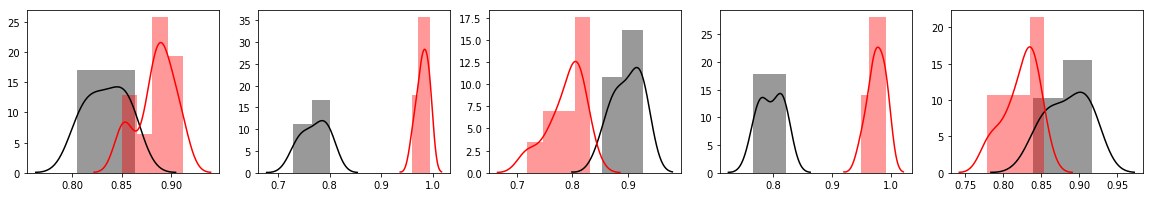

In [42]:
## Distribution by metric

import seaborn as sns

fig, axes = plt.subplots(ncols = 5)
fig.set_size_inches(20, 3)

sns.set_style({'axes.grid' : True})

sns.distplot(b_metrices[:, 0], color='k', ax = axes[0])
sns.distplot(e_metrices[:, 0], color='r', ax = axes[0])
sns.distplot(b_metrices[:, 1], color='k', ax = axes[1])
sns.distplot(e_metrices[:, 1], color='r', ax = axes[1])
sns.distplot(b_metrices[:, 2], color='k', ax = axes[2])
sns.distplot(e_metrices[:, 2], color='r', ax = axes[2])
sns.distplot(b_metrices[:, 3], color='k', ax = axes[3])
sns.distplot(e_metrices[:, 3], color='r', ax = axes[3])
sns.distplot(b_metrices[:, 4], color='k', ax = axes[4])
sns.distplot(e_metrices[:, 4], color='r', ax = axes[4])

fig.show()